# Reevaluate their results + statistical tests

The first part of this file is the same as the one in parse_results.ipynb, but it uses their data not our reproduced ones.
For the new Reevalution-part please go directly to [# Reevaluate their conclusions calc_F1](#1)

<a id='toc'/>

In [304]:
import os, pickle, types
import numpy as np
import pandas as pd
import cython

In [305]:
data_dir = 'data_old'

In [306]:
dat_suffix = ['Edin', 'Glas', 'Melb', 'Osak', 'Toro']
dat_names = ['Edinburgh', 'Glasgow', 'Melbourne', 'Osaka', 'Toronto']

In [307]:
methods_all = ['\\textsc{Random}', '\\textsc{PersTour}', '\\textsc{PersTour-L}', '\\textsc{PoiPopularity}', \
               '\\textsc{PoiRank}', '\\textsc{Markov}', '\\textsc{MarkovPath}', \
               '\\textsc{Rank+Markov}', '\\textsc{Rank+MarkovPath}']

## Latex Table for Recommendation Results

Generate results filenames.

In [308]:
def gen_fname(dat_ix):
    assert(0 <= dat_ix < len(dat_suffix))
    
    suffix = dat_suffix[dat_ix] + '.pkl'
    
    frank = os.path.join(data_dir, 'rank-' + suffix)
    ftran = os.path.join(data_dir, 'tran-' + suffix)
    fcomb = os.path.join(data_dir, 'comb-' + suffix)
    frand = os.path.join(data_dir, 'rand-' + suffix)
    fijcai = os.path.join(data_dir, 'ijcai-' + dat_suffix[dat_ix] + '.pkl')
    return frank, ftran, fcomb, frand, fijcai

Compute the F1 score for recommended trajectory.

In [309]:
def calc_F1(traj_act, traj_rec, noloop=False):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    if noloop == True:
        intersize = len(set(traj_act) & set(traj_rec))
    else:
        match_tags = np.zeros(len(traj_act), dtype=bool)
        for poi in traj_rec:
            for j in range(len(traj_act)):
                if match_tags[j] == False and poi == traj_act[j]:
                    match_tags[j] = True
                    break
        intersize = np.nonzero(match_tags)[0].shape[0]
        
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute the pairs-F1 score for recommended trajectory.

In [310]:
# %load_ext Cython

In [311]:
import numpy as np

def calc_pairsF1(y, y_hat):
    assert(len(y) > 0)
    assert(len(y) == len(set(y))) # no loops in y
    n = len(y)
    nr = len(y_hat)
    n0 = n*(n-1) // 2
    n0r = nr*(nr-1) // 2
    
    # y determines the correct visiting order
    order_dict = dict()
    for i in range(n):
        order_dict[y[i]] = i
        
    nc = 0
    for i in range(nr):
        poi1 = y_hat[i]
        for j in range(i+1, nr):
            poi2 = y_hat[j]
            if poi1 in order_dict and poi2 in order_dict and poi1 != poi2:
                if order_dict[poi1] < order_dict[poi2]: nc += 1

    precision = (1.0 * nc) / (1.0 * n0r)
    recall = (1.0 * nc) / (1.0 * n0)
    if nc == 0:
        F1 = 0
    else:
        F1 = 2. * precision * recall / (precision + recall)
    return F1

Load results data.

In [312]:
def load_results(dat_ix):
    assert(0 <= dat_ix < len(dat_suffix))
    
    frank, ftran, fcomb, frand, fijcai = gen_fname(dat_ix)
    #print(frank)
    assert(os.path.exists(frank))
    #print(ftran)
    assert(os.path.exists(ftran))
    #print(fcomb)
    assert(os.path.exists(fcomb))
    #print(frand)
    assert(os.path.exists(frand))
    #print(fijcai)
    assert(os.path.exists(fijcai))

    # load results data
    recdict_rank = pickle.load(open(frank, 'rb'))
    recdict_tran = pickle.load(open(ftran, 'rb'))
    recdict_comb = pickle.load(open(fcomb, 'rb'))
    recdict_rand = pickle.load(open(frand, 'rb'))
    recdict_ijcai = pickle.load(open(fijcai, 'rb'))
    
    return recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai

Calculate F1-scores from loaded results.

In [313]:
def calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai, func):
    assert(isinstance(func, types.FunctionType) or isinstance(func, types.BuiltinFunctionType))
    
    # deal with missing values: 
    # get rid of recommendation that not all method are successful, due to ILP timeout.
    assert(np.all(sorted(recdict_rank.keys()) == sorted(recdict_tran.keys())))
    assert(np.all(sorted(recdict_rank.keys()) == sorted(recdict_comb.keys())))
    
    keys_all = sorted(recdict_ijcai.keys() & recdict_rank.keys())
    
    rank1 = []; rank2 = []
    for key in keys_all:
        rank1.append(func(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        rank2.append(func(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
    
    tran1 = []; tran2 = []
    for key in keys_all:
        tran1.append(func(recdict_tran[key]['REAL'], recdict_tran[key]['REC_DP']))
        tran2.append(func(recdict_tran[key]['REAL'], recdict_tran[key]['REC_ILP']))

    comb1 = []; comb2 = []
    for key in keys_all:
        comb1.append(func(recdict_comb[key]['REAL'], recdict_comb[key]['REC_DP']))
        comb2.append(func(recdict_comb[key]['REAL'], recdict_comb[key]['REC_ILP']))
            
    rand = []
    for key in keys_all:
        rand.append(func(recdict_rand[key]['REAL'], recdict_rand[key]['REC_RAND']))
    
    ijcai05T = []; ijcai05L = []
    for key in keys_all:
        ijcai05T.append(func(recdict_ijcai[key]['REAL'], recdict_ijcai[key]['REC05T']))
        ijcai05L.append(func(recdict_ijcai[key]['REAL'], recdict_ijcai[key]['REC05L']))
    
    metrics = [rand, ijcai05T, ijcai05L, rank1, rank2, tran1, tran2, comb1, comb2]
    means = [np.mean(x) for x in metrics]
    stds  = [np.std(x)  for x in metrics]
    
    return means, stds, metrics

Generate Latex tables from calculated metrics.

In [314]:
def gen_latex_table(mean_df, std_df, ismax_df, ismax2nd_df, title, label):    
    strs = []
    strs.append('\\begin{table*}[t]\n')
    strs.append('\\caption{' + title + '}\n')
    strs.append('\\label{' + label + '}\n')
    strs.append('\\centering\n')
    strs.append('\\begin{tabular}{l|' + (mean_df.shape[1])*'c' + '} \\hline\n')
    for col in mean_df.columns:
        strs.append(' & ' + col)
    strs.append(' \\\\ \\hline\n')
    for ix in mean_df.index:
        for j in range(mean_df.shape[1]):
            if j == 0: strs.append(ix + ' ')
            jx = mean_df.columns[j]
            strs.append('& $')
            if ismax_df.loc[ix, jx] == True: strs.append('\\mathbf{')
            if ismax2nd_df.loc[ix, jx] == True: strs.append('\\mathit{')
            strs.append('%.3f' % mean_df.loc[ix, jx] + '\\pm' + '%.3f' % std_df.loc[ix, jx])
            if ismax_df.loc[ix, jx] == True or ismax2nd_df.loc[ix, jx] == True: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)

Generate evaluation data tables.

In [315]:
#func = calc_F1
func = calc_pairsF1

In [316]:
methods = methods_all.copy()

mean_df = pd.DataFrame(data=np.zeros((len(methods), len(dat_names)), dtype=float), \
                       columns=dat_names, index=methods)
std_df  = pd.DataFrame(data=np.zeros((len(methods), len(dat_names)), dtype=float), \
                       columns=dat_names, index=methods)

for dat_ix in range(len(dat_suffix)):
    recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai = load_results(dat_ix)
    means, stds,_= calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai, func)
    assert(len(means) == len(stds) == len(methods))
    mean_df[dat_names[dat_ix]] = means
    std_df[dat_names[dat_ix]]  = stds

ismax_df = pd.DataFrame(data=np.zeros(mean_df.shape, dtype=bool), columns=mean_df.columns, index=mean_df.index)
ismax2nd_df = ismax_df.copy()
for col in ismax_df.columns:
    indices = (-mean_df[col]).argsort().values[:2]
    ismax_df.iloc[indices[0]][col] = True
    ismax2nd_df.iloc[indices[1]][col] = True

if func == calc_F1:
    title = '''Performance comparison on five datasets in terms of F$_1$ scores.
    The best method for each dataset (i.e., a column) is shown in bold, the second best is shown in italic.'''
    label = 'tab:f1'
else:
    title = '''Performance comparison on five datasets in terms of pairs-F$_1$ scores.
    The best method for each dataset (i.e., a column) is shown in bold, the second best is shown in italic.'''
    label = 'tab:pairf1'
strs = gen_latex_table(mean_df, std_df, ismax_df, ismax2nd_df, title, label)

print(strs)

\begin{table*}[t]
\caption{Performance comparison on five datasets in terms of pairs-F$_1$ scores.
    The best method for each dataset (i.e., a column) is shown in bold, the second best is shown in italic.}
\label{tab:pairf1}
\centering
\begin{tabular}{l|ccccc} \hline
 & Edinburgh & Glasgow & Melbourne & Osaka & Toronto \\ \hline
\textsc{Random} & $0.261\pm0.155$ & $0.320\pm0.168$ & $0.248\pm0.147$ & $0.304\pm0.142$ & $0.310\pm0.167$ \\
\textsc{PersTour} & $0.417\pm0.343$ & $\mathbf{0.643\pm0.366}$ & $0.216\pm0.265$ & $0.468\pm0.376$ & $0.504\pm0.354$ \\
\textsc{PersTour-L} & $0.359\pm0.207$ & $0.352\pm0.162$ & $0.266\pm0.140$ & $0.406\pm0.238$ & $0.333\pm0.163$ \\
\textsc{PoiPopularity} & $\mathit{0.436\pm0.259}$ & $0.507\pm0.298$ & $0.316\pm0.178$ & $0.365\pm0.190$ & $0.384\pm0.201$ \\
\textsc{PoiRank} & $0.432\pm0.251$ & $\mathit{0.548\pm0.311}$ & $0.339\pm0.203$ & $\mathbf{0.511\pm0.309}$ & $\mathbf{0.518\pm0.296}$ \\
\textsc{Markov} & $0.417\pm0.248$ & $0.495\pm0.296$ & $0.288\pm

<a id="1"></a>
# Reevaluate their conclusions calc_F1:
For each of the data sets ['Edin', 'Glas', 'Melb', 'Osak', 'Toro'] -> [0-Edin, 1-Glas,...]. We want a visualization of their results


Text(0.5, 1.0, 'Edinburgh')

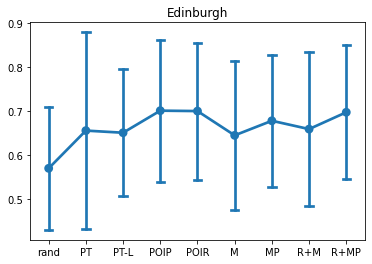

In [317]:
from matplotlib import pyplot as plt
import seaborn as sns

#test with Edinburgh -> 0
recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai=load_results(0)
means, stds, metrics=calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai,calc_F1)

#using pointplot from sns


data=pd.DataFrame()
col=["rand", "PT", "PT-L", "POIP", "POIR", "M", "MP", "R+M", "R+MP"]
for i in range(9):
    data[col[i]]=metrics[i]
ax=sns.pointplot(data=data,ci="sd",capsize=0.2)
ax.set_title("Edinburgh")

**Why it is better to use standard error of the mean (sem) than standard deviation?**

*So, if we want to say how widely scattered some measurements are, we use the standard deviation. If we want to indicate the uncertainty around the estimate of the mean measurement, we quote the standard error of the mean. The standard error is most useful as a means of calculating a confidence interval. For a large sample, a 95% confidence interval is obtained as the values 1.96×SE either side of the mean. We will discuss confidence intervals in more detail in a subsequent Statistics Note. The standard error is also used to calculate P values in many circumstances.* (Text from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1255808 Zugriff 29.01.22):

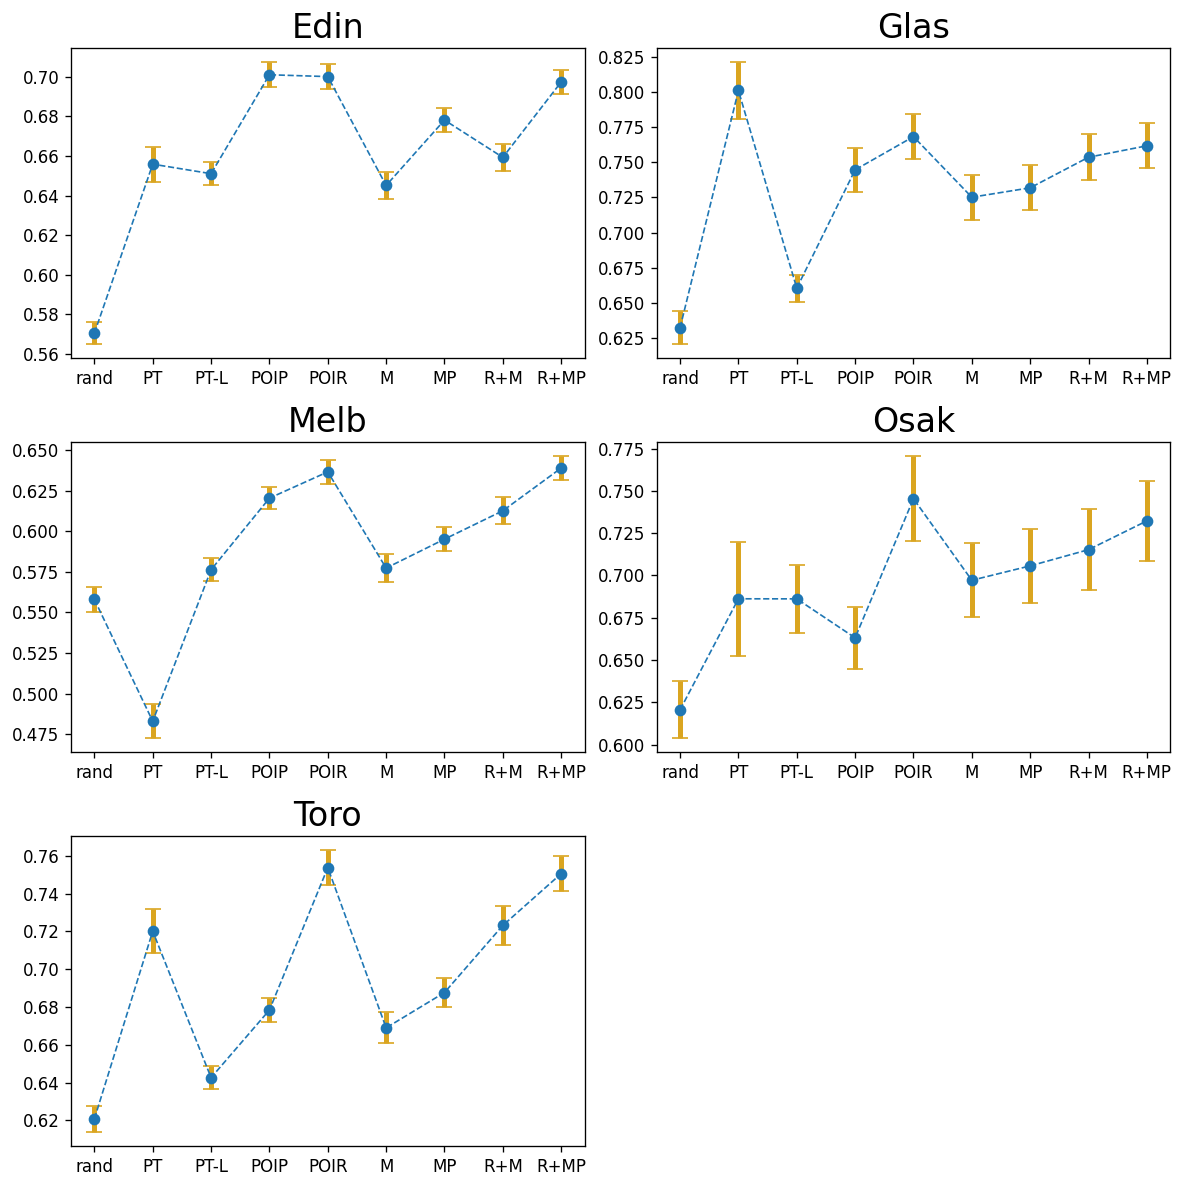

In [318]:
#using matplotlib -> more flexibel with the error bars
#plot with std-error of the mean -> sd/sqrt(n) confidence Interval would be 1.96

'''
we show all the datasets here, in the report we only picked 2 of them (Edin & Osaka)
to reproduce the exact same figures as in our report, please uncomment the commented #here files
'''
# here: fig=plt.figure(figsize=(10, 3),dpi=120)
fig=plt.figure(figsize=(10, 10),dpi=120)
fig.tight_layout()
data=['Edin', 'Glas', 'Melb', 'Osak', 'Toro']
# here: for i,di in zip(range(2),[0,3]):
for i,di in zip(range(5),range(5)):
    ax3=fig.add_subplot(3,2,i+1)
    recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai=load_results(di)
    means, stds, metrics=calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai,calc_F1)
    n=len(metrics[0])
    ax3.errorbar(x=range(9),y=means,yerr=stds/np.sqrt(n),marker='o',capsize=5,ecolor="goldenrod",linestyle="dashed",linewidth=1,elinewidth=3)
    ax3.set_xticks(range(9))
    ax3.set_xticklabels(col,fontsize=10)
    ax3.set_title(data[di],fontsize=20)

fig.tight_layout()

#t-tests:
reason for choosing paired t-test:
- the data is the same only the algorithm changes, therefore we can use the paired t-test for comparision
- we only test the best algorithm for each dataset with the others
- because we do multiple test we use the bonferoni correction in order to not inflate the possibility of making type 1 error
- alpha=5% -> alpha_corrected=5/8%=0.625%
- if the pvalue is greater than 0.625% we then reject the H_0 and we can conclude that this algorithm really performs better than the others
- H_0: there is no difference between these two values (orange)
- H_1: best is really greater/better than rest (green)

In [319]:
#paired t-test
from scipy import stats
biglist=[]
datasets=['Edin', 'Glas', 'Melb', 'Osak', 'Toro']
#Edinburgh:
for j in range(5):
    recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai=load_results(j)
    means, stds, metrics=calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai,calc_F1)

    best=means.index(max(means))
    col=["rand", "PT", "PT-L", "POIP", "POIR", "M", "MP", "R+M", "R+MP"]
    listerl=[]
    for i in range(9):
        a=stats.ttest_rel(metrics[best],metrics[i],alternative="greater")
        listerl.append((col[i],a.pvalue))
    df=pd.DataFrame(listerl,columns=["algos",datasets[j]])
    df.set_index("algos",inplace=True)
    biglist.append(df)

from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['algos'],
                                                how='outer'), biglist)
df_merged.fillna(value=1,inplace=True)
pd.options.display.float_format = '{:.5f}'.format
df_merged

,Edin,Glas,Melb,Osak,Toro
algos,,,,,
rand,0.00000,0.00000,0.00000,0.00004,0.00000
PT,0.00000,1.00000,0.00000,0.04841,0.00236
PT-L,0.00000,0.00000,0.00000,0.02335,0.00000
POIP,1.00000,0.00294,0.00298,0.00385,0.00000
POIR,0.41061,0.06694,0.34905,1.00000,1.00000
M,0.00000,0.00030,0.00000,0.03107,0.00000
MP,0.00028,0.00093,0.00000,0.05814,0.00000
R+M,0.00000,0.01515,0.00000,0.05554,0.00000
R+MP,0.23036,0.03792,1.00000,0.22100,0.28018


In [320]:
a=df_merged[df_merged>0.00625]
a.fillna(value="-") #every NAN value is significantly worse then the best

,Edin,Glas,Melb,Osak,Toro
algos,,,,,
rand,-,-,-,-,-
PT,-,1.00000,-,0.04841,-
PT-L,-,-,-,0.02335,-
POIP,1.00000,-,-,-,-
POIR,0.41061,0.06694,0.34905,1.00000,1.00000
M,-,-,-,0.03107,-
MP,-,-,-,0.05814,-
R+M,-,0.01515,-,0.05554,-
R+MP,0.23036,0.03792,1.00000,0.22100,0.28018


In [321]:
#maybe useful for coloring table
df_merged.to_csv("data_old/calcF1.csv",sep="\t",decimal=",")

# Reevaluate their conclusions calc_pairsF1:

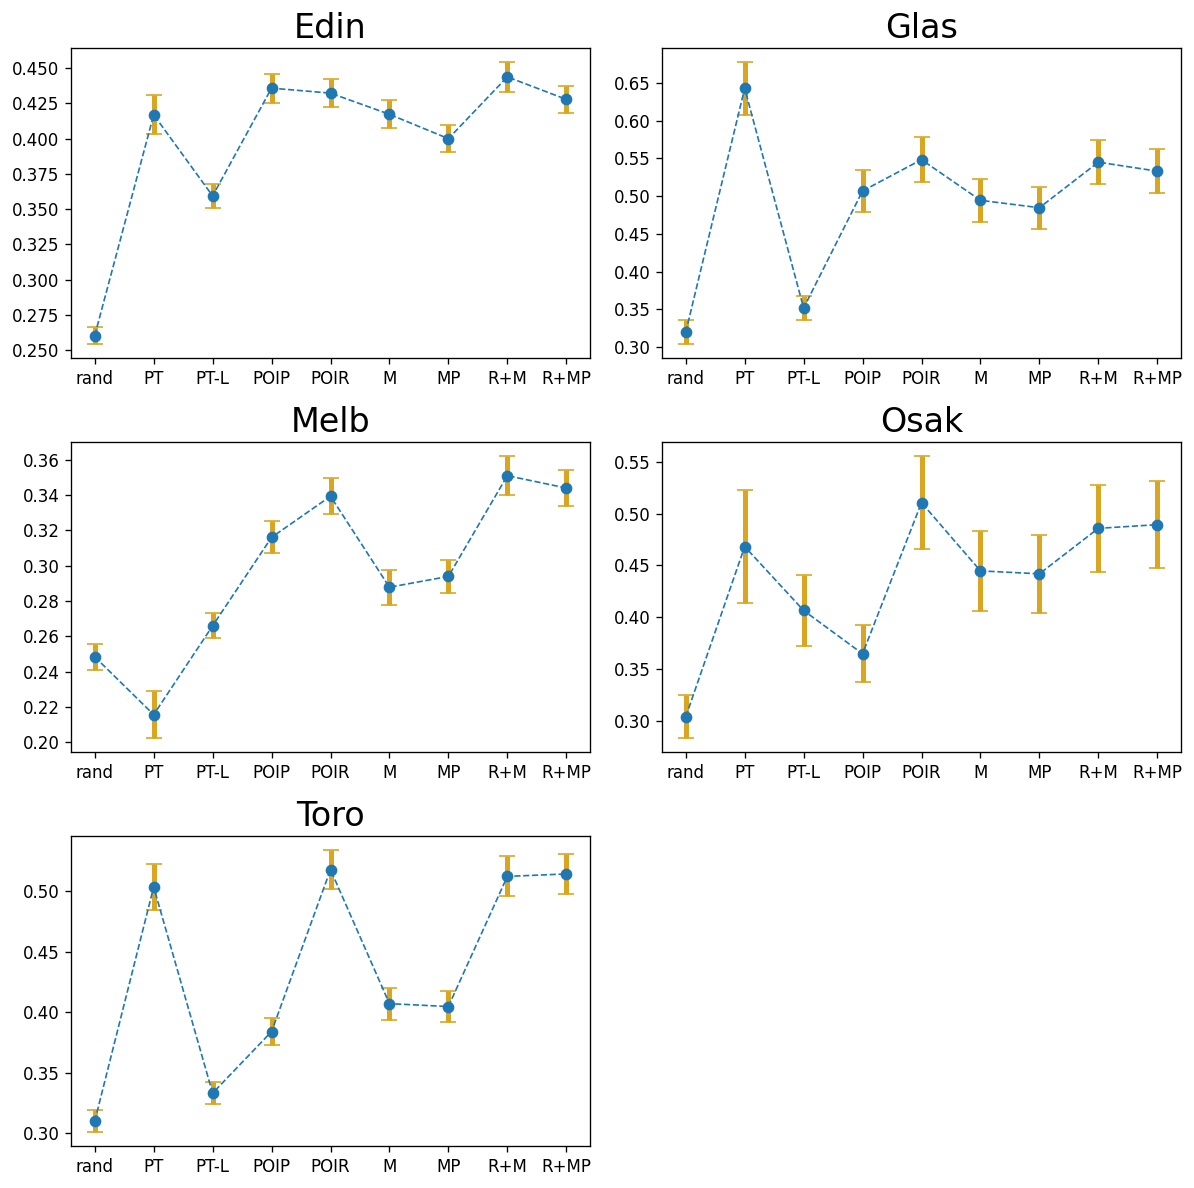

In [322]:
#using matplotlib -> more flexibel with the error bars
#plot with std-error of the mean -> sd/sqrt(n) confidence Interval would be 1.96

'''
we show all the datasets here, in the report we only picked 2 of them (Edin & Osaka)
to reproduce the exact same figures as in our report, please uncomment the commented #here files
'''
# here: fig=plt.figure(figsize=(10, 3),dpi=120)
fig=plt.figure(figsize=(10, 10),dpi=120)
fig.tight_layout()
data=['Edin', 'Glas', 'Melb', 'Osak', 'Toro']
# here: for i,di in zip(range(2),[0,3]):
for i,di in zip(range(5),range(5)):
    ax3=fig.add_subplot(3,2,i+1)
    recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai=load_results(di)
    means, stds, metrics=calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai,calc_pairsF1)
    n=len(metrics[0])
    ax3.errorbar(x=range(9),y=means,yerr=stds/np.sqrt(n),marker='o',capsize=5,ecolor="goldenrod",linestyle="dashed",linewidth=1,elinewidth=3)
    ax3.set_xticks(range(9))
    ax3.set_xticklabels(col,fontsize=10)
    ax3.set_title(data[di],fontsize=20)

fig.tight_layout()

#t-tests:
reason for choosing paired t-test:
- the data is the same only the algorithm changes, therefore we can use the paired t-test for comparision
- we only test the best algorithm for each dataset with the others
- because we do multiple test we use the bonferoni correction in order to not inflate the possibility of making type 1 error
- alpha=5% -> alpha_corrected=5/8%=0.625%
- if the pvalue is greater than 0.625% we then reject the H_0 and we can conclude that this algorithm really performs better than the others
- H_0: there is no difference between these two values (orange)
- H_1: best is really greater/better than rest (green)

In [323]:
#paired t-test
from scipy import stats
biglist=[]
datasets=['Edin', 'Glas', 'Melb', 'Osak', 'Toro']
#Edinburgh:
for j in range(5):
    recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai=load_results(j)
    means, stds, metrics=calc_metrics(recdict_rank, recdict_tran, recdict_comb, recdict_rand, recdict_ijcai,calc_pairsF1)

    best=means.index(max(means))
    col=["rand", "PT", "PT-L", "POIP", "POIR", "M", "MP", "R+M", "R+MP"]
    listerl=[]
    for i in range(9):
        a=stats.ttest_rel(metrics[best],metrics[i],alternative="greater")
        listerl.append((col[i],a.pvalue))
    df=pd.DataFrame(listerl,columns=["algos",datasets[j]])
    df.set_index("algos",inplace=True)
    biglist.append(df)

from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['algos'],
                                                how='outer'), biglist)
df_merged.fillna(value=1,inplace=True)
pd.options.display.float_format = '{:.5f}'.format
df_merged

,Edin,Glas,Melb,Osak,Toro
algos,,,,,
rand,0.00000,0.00000,0.00000,0.00007,0.00000
PT,0.04581,1.00000,0.00000,0.23302,0.23755
PT-L,0.00000,0.00000,0.00000,0.02620,0.00000
POIP,0.18602,0.00010,0.00167,0.00379,0.00000
POIR,0.05489,0.00790,0.15534,1.00000,1.00000
M,0.00108,0.00014,0.00000,0.08295,0.00000
MP,0.00000,0.00004,0.00000,0.07155,0.00000
R+M,1.00000,0.00670,1.00000,0.22660,0.28949
R+MP,0.00010,0.00267,0.03456,0.24745,0.35662


In [324]:
a=df_merged[df_merged>0.00625]
#every NAN value is significantly worse then the best

a.fillna(value="-")

,Edin,Glas,Melb,Osak,Toro
algos,,,,,
rand,-,-,-,-,-
PT,0.04581,1.00000,-,0.23302,0.23755
PT-L,-,-,-,0.02620,-
POIP,0.18602,-,-,-,-
POIR,0.05489,0.00790,0.15534,1.00000,1.00000
M,-,-,-,0.08295,-
MP,-,-,-,0.07155,-
R+M,1.00000,0.00670,1.00000,0.22660,0.28949
R+MP,-,-,0.03456,0.24745,0.35662


In [325]:
#maybe useful for coloring table
df_merged.to_csv("data_old/calc_pairsF1.csv")